## 1. Network Structure

## Step1.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug  5 22:38:51 2019

@author: Jones
"""

"""
Consider complex input
"""
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D,Conv1D, MaxPooling2D, MaxPooling1D, Flatten, ZeroPadding2D, ZeroPadding1D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
import os
import matplotlib.pyplot as plt
import time
from tqdm import tnrange, tqdm_notebook
import pandas as pd
import tensorflow as tf
import math
%matplotlib inline

working_dir = os.getcwd()

#Indicate your simulated data path
gen_folder_path = os.path.join(working_dir, 'BaselineNorm_42ppm_gen_folder')

#del model
keras.backend.clear_session()

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

###############################################################
#Want to build new model: bulid_model_flag = 1
#Just want import library and load trained model/weghting: bulid_model_flag = 0
###############################################################
bulid_model_flag = 1


if bulid_model_flag :
    model = Sequential()
    input_shape_num = 774#for LCM basis

    #k = 1000#total lines
    #height x width x channel x array = input_shape_num, 1,1,k

    block_1_filter_num = 32
    conv_filter_size = 15

    ############block 1###############

    model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1, input_shape=(input_shape_num,1),dtype='float32'))
    model.add(BatchNormalization(scale=False, center=False))#?????
    model.add(Activation('relu'))

    model.add(ZeroPadding1D(padding = (7)))
    model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1))
    model.add(BatchNormalization(scale=False, center=False))#?????
    model.add(Activation('relu'))

    model.add(ZeroPadding1D(padding = (7)))
    model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1))
    model.add(BatchNormalization(scale=False, center=False))#?????
    model.add(Activation('relu'))

    model.add(ZeroPadding1D(padding = (7)))
    model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1))
    model.add(BatchNormalization(scale=False, center=False))#?????
    model.add(Activation('relu'))
    model.add(MaxPooling1D((2)))#Why not 1D?

    ############block 2###############
    block_2_filter_num = 64
    for nrep in range(4):
        model.add(ZeroPadding1D(padding = (7)))
        model.add(Conv1D(filters=block_2_filter_num, kernel_size=(15), strides=1))    
        model.add(BatchNormalization(scale=False, center=False))#?????
        model.add(Activation('relu'))
    model.add(MaxPooling1D((2)))#Why not 1D?
    ############block 3###############
    block_3_filter_num = 128
    for nrep in range(4):
        model.add(ZeroPadding1D(padding = (7)))
        model.add(Conv1D(filters=block_2_filter_num, kernel_size=(15), strides=1))
        model.add(BatchNormalization(scale=False, center=False))#?????
        model.add(Activation('relu'))

    ###########FC, Regression##############
    model.add(Flatten())
    model.add(Dense(input_shape_num, activation = "linear"))
    model.summary()
    #sgdm = SGD(lr=1e-1, momentum= 0.8, decay=1.0291e-4)#type 1
    #sgdm = SGD(lr=3e-8, momentum= 0.8)#type 2
    sgdm = SGD(lr=0.01, momentum= 0.8)#type 3, 2020
    #sgdm = SGD(lr=0.01)#type 4,default?, 2020
    ######SGD######
    #model.compile(loss = 'mse', optimizer='sgd',  metrics=['mape'])
    #model.compile(loss = 'mse', optimizer=sgdm,  metrics=['mape'])
    
    ####Huber Loss#####
    huber_delta = 2e+12
    def Huber(labels, predictions, delta=huber_delta):
        error = tf.abs(tf.subtract(labels ,predictions))
        condition = tf.less(error, delta)#像是判別式
        small_res = 0.5 * tf.square(error) ##誤差小遵照L2
        large_res = delta * error - 0.5 * tf.square(delta) ## 誤差大採用線性誤差
        result = tf.where(condition, small_res, large_res)#huber_loss
        return tf.reduce_mean(result)
    model.compile(loss = Huber, optimizer='sgd',  metrics=['mape'])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 760, 32)           512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 760, 32)           64        
_________________________________________________________________
activation_1 (Activation)    (None, 760, 32)           0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 774, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 760, 32)           15392     
_________________________________________________________________
batch_normalization_2 (Batch (None, 760, 32)           64        
_________________________________________________________________
acti

## Read spectrum data and metabolite concectration table

Read and concatenate read data and conc. table for splitting

***If you just want load the "brain_conc_set" file imdex, set "flag_read_full_data" = 0 ***

## Step 2.

In [2]:
import time
from tqdm import tnrange, tqdm_notebook
import pandas as pd

flag_read_full_data = 1

if (flag_read_full_data):
    crop_len = [837,774,467]#for difference type basis
    tmp_X = np.zeros((50000,crop_len[1],),dtype=np.csingle)
    tmp_Y = np.zeros((50000,crop_len[1],),dtype=np.csingle)
    files = [ f for f in os.listdir(gen_folder_path) if os.path.isfile(os.path.join(gen_folder_path,f)) ]

    for idx, cont in enumerate(tqdm_notebook(files)):
        read_data= np.load(os.path.join(gen_folder_path, cont))
        tmp_X[idx,:] = read_data['X']
        tmp_Y[idx,:] = read_data['Y']
    read_X = np.expand_dims(tmp_X,axis = 2)
    read_Y = tmp_Y

######################################
# Load conc. table
######################################
rd = np.load(os.path.join(working_dir,'42ppm_base_basis_set.npz'))

base_basis_set = rd['data']

brain_betabo_conc_table_path = os.path.join(gen_folder_path, 'brain_betabo_conc_table_df')
brain_betabo_conc_table_files = [ f for f in os.listdir(brain_betabo_conc_table_path) if os.path.isfile(os.path.join(brain_betabo_conc_table_path,f)) ]

brain_conc_set = []

if (flag_read_full_data==0):
    for idx in tqdm_notebook(brain_betabo_conc_table_files[:2]):
        read_data= pd.read_pickle(os.path.join(brain_betabo_conc_table_path, idx))
        read_data.set_index("names" , inplace=True)
        brain_conc_set.append(read_data['conc'])
else:
    for idx in tqdm_notebook(brain_betabo_conc_table_files):
        read_data= pd.read_pickle(os.path.join(brain_betabo_conc_table_path, idx))
        read_data.set_index("names" , inplace=True)
        brain_conc_set.append(read_data['conc'])
print('brain_conc_set',(brain_conc_set[0]))

np_brain_conc_set = np.array(brain_conc_set)

if (flag_read_full_data):
    #Concatenate read data and conc. table for splitting
    read_Y_conc_set = np.concatenate((read_Y, np_brain_conc_set), axis = 1)

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))


brain_conc_set names
Ala        1.241054
Asp        1.331657
Cr         8.005503
GABA       1.518046
Glc        1.163422
Gln        3.767831
Glu       11.020463
GPC        0.573307
PCh        0.660458
Lac        0.479394
mI         4.750587
NAA       16.952625
NAAG       0.690578
Scyllo     0.000000
Tau        2.245158
Name: conc, dtype: float64


## Model training config: Early stopping...、Tensor borad

## Step 3.

In [16]:
from keras.callbacks import TensorBoard
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#tensorboard --logdir ./logs 

cb_path = './nofc_sgd_NormMM_huborloss_del_2e12'

tbCallBack = TensorBoard(log_dir=cb_path,# log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)
earlystopper = EarlyStopping(patience=30,monitor='val_loss', mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath = cb_path+'/TP1.h5',monitor='val_loss',mode='min')
reducelronplateau = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-7, verbose=1)

./nofc_sgd_NormMM_huborloss_del_2e12/TP1.h5


"\nCheckpoints =[EarlyStopping(patience=8,monitor='val_loss', mode='min', verbose=1),\n              ModelCheckpoint(filepath = cb_path+'/TP1.h5',monitor='val_loss',mode='min'),\n              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5, verbose=1)]\n#EarlyStopping: 当被监测的数量沒有變得更好，则停止训练。 In min mode, training will stop when the quantity monitored has stopped decreasing\n#ModelCheckpoint(filepath = './TP1.h5',monitor='val_loss',mode='min'),\n#os.path.join(cb_path,weights.{epoch:02d}-{val_loss:.2f}.h5)\nclass SGDLearningRateTracker(Callback):\n    def on_epoch_end(self, epoch, logs={}):\n        optimizer = self.model.optimizer\n        lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))\n        print('\nLR: {:.6f}\n'.format(lr))\n# define your model\n\n#model.fit(x, y, callbacks=[SGDLearningRateTracker()])\n"

## (Optional) If want to load previous model, execute this cell

In [100]:

from keras.models import load_model
#Use it if model had been trained
#model = load_model('Feb-19-00-2020.h5')#LCM basis, adam, nofc, MMnorm,sgdm,lr0.01,m0.8
#model = load_model(os.path.join(working_dir,'nofc_sgd_default_NormMM_kol_new_logs','0_TP1.h5'))#

## Split training and testing data (Include metabo conc. table)

## Step 4.

In [44]:
########################new model
from sklearn.model_selection import train_test_split
##(input_shape_num,1,2)

X_train, X_test, Y_train_conc , Y_test_conc = train_test_split(read_X, read_Y_conc_set, test_size = 0.1, random_state = 42)

X_train = X_train[:,:,0]
X_test = X_test[:,:,0]

print('X_train:',X_train.shape)
print('X_test:',X_test.shape)

Y_train = Y_train_conc[:,:-15]
Y_test = Y_test_conc[:,:-15]
conc_table_train = Y_train_conc[:,-15:].real
conc_table_test = Y_test_conc[:,-15:].real

print('conc_table_train',conc_table_train.shape)
print('conc_table_test',conc_table_test.shape)
print('Y_train',Y_train.shape)
print('Y_test',Y_test.shape)

X_train = np.expand_dims(X_train.real, axis = 2)
#X_train = np.expand_dims(X_train, axis = 2)

X_test = np.expand_dims(X_test.real, axis = 2)
#X_test = np.expand_dims(X_test, axis = 2)

print('X_train:',X_train.shape)
print('X_test:',X_test.shape)

X_train: (45000, 774)
X_test: (5000, 774)
conc_table_train (45000, 15)
conc_table_test (5000, 15)
Y_train (45000, 774)
Y_test (5000, 774)
X_train: (45000, 774, 1)
X_test: (5000, 774, 1)


## kfold (Skip here if you only want to train single model)

In [3]:
from sklearn.model_selection import KFold,StratifiedKFold
from keras.backend.tensorflow_backend import set_session

from keras.callbacks import TensorBoard
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#tensorboard --logdir ./logs 
import datetime

cb_path = './nofc_sgd_default_NormMM_kol_new_logs'

tbCallBack = TensorBoard(log_dir=cb_path,# log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)
earlystopper = EarlyStopping(patience=30,monitor='val_loss', mode='min', verbose=1)
reducelronplateau = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-7, verbose=1)

print(read_X.shape)
print(read_Y_conc_set.shape)

sfolder = StratifiedKFold(n_splits=10,random_state=0,shuffle=False)
floder = KFold(n_splits=10,random_state=0,shuffle=False)

kfold_idx = 0
cvscores = []
for train_idx, test_idx in floder.split(read_X[:,:,0].real,read_Y_conc_set):
    print(f'############## Now is {kfold_idx} fold##############')
    ####################rebuild model####################
    if kfold_idx != 0:
        del model
        keras.backend.clear_session()
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.7
        set_session(tf.Session(config=config))
    
    bulid_model_flag = 1
    if bulid_model_flag :
        model = Sequential()
        input_shape_num = 774#for LCM basis
        block_1_filter_num = 32
        conv_filter_size = 15
        ############block 1###############
        model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1, input_shape=(input_shape_num,1),dtype='float32'))
        model.add(BatchNormalization(scale=False, center=False))#?????
        model.add(Activation('relu'))
        model.add(ZeroPadding1D(padding = (7)))
        model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1))
        model.add(BatchNormalization(scale=False, center=False))#?????
        model.add(Activation('relu'))
        model.add(ZeroPadding1D(padding = (7)))
        model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1))
        model.add(BatchNormalization(scale=False, center=False))#?????
        model.add(Activation('relu'))
        model.add(ZeroPadding1D(padding = (7)))
        model.add(Conv1D(filters=block_1_filter_num, kernel_size=(15), strides=1))
        model.add(BatchNormalization(scale=False, center=False))#?????
        model.add(Activation('relu'))
        model.add(MaxPooling1D((2)))#Why not 1D?
        ############block 2###############
        block_2_filter_num = 64
        for nrep in range(4):
            model.add(ZeroPadding1D(padding = (7)))
            model.add(Conv1D(filters=block_2_filter_num, kernel_size=(15), strides=1))    
            model.add(BatchNormalization(scale=False, center=False))#?????
            model.add(Activation('relu'))
        model.add(MaxPooling1D((2)))#Why not 1D?
        ############block 3###############
        block_3_filter_num = 128
        for nrep in range(4):
            model.add(ZeroPadding1D(padding = (7)))
            model.add(Conv1D(filters=block_2_filter_num, kernel_size=(15), strides=1))
            model.add(BatchNormalization(scale=False, center=False))#?????
            model.add(Activation('relu'))
        ###########FC, Regression##############
        model.add(Flatten())
        model.add(Dense(input_shape_num, activation = "linear"))
        #model.add(Dense(input_shape_num, kernel_regularizer=l2(0.0001), activation = "linear"))
        #model.summary()
        #sgdm = SGD(lr=1e-1, momentum= 0.8, decay=1.0291e-4)#type 1

        model.compile(loss = 'mse', optimizer='sgd',  metrics=['mape'])
    ####################rebuild model####################
    ####################Split data####################
    X_train, X_test = read_X[train_idx,:,0], read_X[test_idx,:,0]
    Y_train_conc , Y_test_conc = read_Y_conc_set[train_idx], read_Y_conc_set[test_idx]
    Y_train = Y_train_conc[:,:-15]
    Y_test = Y_test_conc[:,:-15]
    conc_table_train = Y_train_conc[:,-15:].real
    conc_table_test = Y_test_conc[:,-15:].real
    X_train = np.expand_dims(X_train.real, axis = 2)
    X_test = np.expand_dims(X_test.real, axis = 2)
    #print('X_train:',X_train.shape)
    #print('X_test:',X_test.shape)
    ####################Split data####################
    ###################tb##########################
    checkpointer = ModelCheckpoint(filepath = os.path.join(working_dir,cb_path[2:],f'{kfold_idx}_TP1.h5'),monitor='val_loss',mode='min')
    ###################tb##########################
    model.fit(X_train, Y_train,verbose=0, epochs=110, validation_split=0.1 , batch_size=32, callbacks=[tbCallBack,TQDMNotebookCallback(),earlystopper,checkpointer ,reducelronplateau])
    #To check tensorboard , please cd to the current folder and:
    #tensorboard --logdir ./logs
    #today = datetime.datetime.now()
    #kfold_idx_model_date = today.strftime("%b-%d-%H-%Y")+'_'+str(kfold_idx)+'.h5'
    #model.save(os.path.join(working_dir,cb_path[2:],kfold_idx_model_date))
    scores = model.evaluate(X_test, Y_test, verbose=0)
    cvscores.append(scores)
    print(f'The {kfold_idx} fold done')
    kfold_idx += 1

(50000, 774, 1)
(50000, 789)
############## Now is 0 fold##############
Instructions for updating:
Use tf.cast instead.


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 0 fold done
############## Now is 1 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.0005497557576745749.


HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 1 fold done
############## Now is 2 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 2 fold done
############## Now is 3 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00095: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 3 fold done
############## Now is 4 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.0005497557576745749.


HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00104: ReduceLROnPlateau reducing learning rate to 0.0004398046061396599.


HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 4 fold done
############## Now is 5 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 5 fold done
############## Now is 6 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 6 fold done
############## Now is 7 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 7 fold done
############## Now is 8 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00110: ReduceLROnPlateau reducing learning rate to 0.0005497557576745749.

The 8 fold done
############## Now is 9 fold##############


HBox(children=(IntProgress(value=0, description='Training', max=110, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00086: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


The 9 fold done


## Start training then save model.

## Step 5.

In [18]:
import datetime
today = datetime.datetime.now()
sav_model_date = today.strftime("%b-%d-%H-%Y")+'.h5'

model.reset_states()
#################Start training#####################
model.fit(X_train, Y_train,verbose=0, epochs=200, validation_split=0.1 , batch_size=32, callbacks=[tbCallBack,TQDMNotebookCallback(),earlystopper,checkpointer ,reducelronplateau])

#To check tensorboard , please cd to the current folder and:
#tensorboard --logdir ./logs 

model.save(sav_model_date)


HBox(children=(IntProgress(value=0, description='Training', max=200, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


HBox(children=(IntProgress(value=0, description='Epoch 1', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.


HBox(children=(IntProgress(value=0, description='Epoch 13', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.


HBox(children=(IntProgress(value=0, description='Epoch 32', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.


HBox(children=(IntProgress(value=0, description='Epoch 40', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.


HBox(children=(IntProgress(value=0, description='Epoch 57', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.


HBox(children=(IntProgress(value=0, description='Epoch 68', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00076: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.


HBox(children=(IntProgress(value=0, description='Epoch 76', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0020971518009901048.


HBox(children=(IntProgress(value=0, description='Epoch 81', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00086: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.


HBox(children=(IntProgress(value=0, description='Epoch 86', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00092: ReduceLROnPlateau reducing learning rate to 0.0013421771116554739.


HBox(children=(IntProgress(value=0, description='Epoch 92', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.001073741726577282.


HBox(children=(IntProgress(value=0, description='Epoch 105', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00110: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.


HBox(children=(IntProgress(value=0, description='Epoch 110', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 111', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 112', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 113', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 114', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 115', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 116', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0006871947087347508.


HBox(children=(IntProgress(value=0, description='Epoch 117', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 118', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 119', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 120', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 121', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 122', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 123', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 124', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 125', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 126', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 127', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 128', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 129', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.0005497557576745749.


HBox(children=(IntProgress(value=0, description='Epoch 130', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 131', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 132', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 133', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 134', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00135: ReduceLROnPlateau reducing learning rate to 0.0004398046061396599.


HBox(children=(IntProgress(value=0, description='Epoch 135', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 136', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 137', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 138', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 139', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 140', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 141', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 142', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 143', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 144', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.00035184368025511505.


HBox(children=(IntProgress(value=0, description='Epoch 145', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 146', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 147', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 148', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 149', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00150: ReduceLROnPlateau reducing learning rate to 0.0002814749488607049.


HBox(children=(IntProgress(value=0, description='Epoch 150', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 151', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 152', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 153', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 154', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 155', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 156', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 157', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 158', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 159', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 160', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 161', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 162', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00163: ReduceLROnPlateau reducing learning rate to 0.0002251799684017897.


HBox(children=(IntProgress(value=0, description='Epoch 163', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 164', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 165', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 166', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 167', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 168', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 169', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 170', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00171: ReduceLROnPlateau reducing learning rate to 0.0001801439793780446.


HBox(children=(IntProgress(value=0, description='Epoch 171', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 172', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 173', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 174', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 175', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 176', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 177', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 178', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.00014411518350243568.


HBox(children=(IntProgress(value=0, description='Epoch 179', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 180', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 181', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 182', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 183', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00184: ReduceLROnPlateau reducing learning rate to 0.00011529214680194855.


HBox(children=(IntProgress(value=0, description='Epoch 184', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 185', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 186', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 187', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 188', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00189: ReduceLROnPlateau reducing learning rate to 9.223371744155885e-05.


HBox(children=(IntProgress(value=0, description='Epoch 189', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 190', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 191', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 192', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 193', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))


Epoch 00194: ReduceLROnPlateau reducing learning rate to 7.378697628155351e-05.


HBox(children=(IntProgress(value=0, description='Epoch 194', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 195', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 196', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 197', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 198', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 199', max=40500, style=ProgressStyle(description_width='initial')), HTML(value='')))

## Prediction plot

In [21]:
%matplotlib qt
##################Predict##################
#loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=128)
pred_res = model.predict(X_test, verbose=1)

##################Predict##################

##################plot ppm config##################
#for lcm basis, 0
#gamma, 1
choice = 0

basis_sample_point = [4096,4944]
basis_BW = [2500,4823]
basis_B = [127.75, 123.23]

sample_point = basis_sample_point[choice]
BW = basis_BW[choice]
B = basis_B[choice]

ppm_length = BW/B#16.xx ppm
ppm_center = 4.7
min_bound = ppm_center - (ppm_length)/2
max_bound = ppm_center + (ppm_length)/2
ppm = np.linspace(min_bound, max_bound, sample_point)
ppm = ppm[::-1]#reverse

###Original####
pos = np.where((ppm>=0.5) & (ppm<=4.2))
crop_ppm = ppm[pos]
##################plot ppm config##################

pred_res_view = pred_res
print('pred_res.shape!!',pred_res.shape)#(2, 837)

#X_test_view = X_test[:,:,:,0] + 1j*(X_test[:,:,:,1])
X_test_view = X_test
#Y_test_view = Y_test[:,:774] + 1j*(Y_test[:,774:])
Y_test_view = Y_test
#X_test_view = X_test_view*10

#plot total mse on test set
total_err = Y_test_view.real - pred_res_view.real
total_err_sqr = np.square(total_err)
total_msep = (np.mean(total_err_sqr,axis = 1)/np.max(total_err_sqr, axis = 1))*100

plt.figure(figsize=(15,5))
plt.title('Total MSE%')
plt.plot(total_msep,'.')


td = np.array(np.where(total_msep > 0))[0]
td = td[:8]
print('td shape',td.shape)

#num = 10
#for num in range(2):
for num in td:
    #plt.figure(figsize=(15,15))
    plt.figure(figsize=(15,7))#寬, 高
    #plt.subplot(311)
    #plt.subplot(211)
    plt.title('Predicion result')
    plt.plot(crop_ppm, X_test_view[num],color='gray',label='input')
    plt.xlim(crop_ppm.max(),crop_ppm.min())
    #plt.subplot(312)
    #plt.subplot(212)
    #plt.title('pred_res')
    plt.plot(crop_ppm, pred_res_view[num],label = 'pred_res',color='b')
    plt.xlim(crop_ppm.max(),crop_ppm.min())
    #plt.xlim(500,540)
    #plt.ylim(0,6e7)
    #plt.subplot(413)
    #plt.title('Y_test')
    plt.plot(crop_ppm, Y_test_view[num],label = 'Y_test',color='r')
    plt.xlim(crop_ppm.max(),crop_ppm.min())    
    #plt.legend(loc='upper right')
    #plt.xlim(500,540)
    #plt.ylim(0,6e7)
   
    #plt.subplot(313)
    err = ((Y_test_view[num]).real- (pred_res_view[num]).real)
    err_square = np.square(err)    
    msep = (np.mean(err_square)/err_square.max())*100
    #plt.title(f'res mse%{round(msep, 2)}')
    plt.plot(crop_ppm, err,color='k',label = f'res mse%{round(msep, 2)}')
    plt.xlim(crop_ppm.max(),crop_ppm.min())    
    plt.legend(loc='upper right',fontsize=15)
    #print(max(abs(err)))
    #plt.ylim(-1e6,3e+7)


5000/5000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 218us/step
pred_res.shape!! (5000, 774)
td shape (8,)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


## Quantification

[[0, 'Ala'], [1, 'Asp'], [2, 'Cr'], [3, 'GABA'], [4, 'Glc'], [5, 'Gln'], [6, 'Glu'], [7, 'GPC'], [8, 'PCh'], [9, 'Lac'], [10, 'mI'], [11, 'NAA'], [12, 'NAAG'], [13, 'tNAA'], [14, 'tCr'], [15, 'tCho'], [16, 'Glx'], [17, 'Glx/tCr'], [18, 'mI/tCr'], [19, 'tCho/tCr'], [20, 'tNAA/Cr']]
5000


HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))


                Cr          Glu          Gln          NAA         NAAG  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      2.730140     6.228007    11.358360     2.804381    22.076819   
std       2.473213     5.330469     9.252508     2.633941    25.232051   
min       0.000305     0.001220     0.010639     0.001158     0.000826   
25%       0.937275     2.295740     4.417062     0.957737     6.315096   
50%       2.052184     4.835351     9.294013     2.116545    14.127809   
75%       3.804350     8.711569    15.767403     3.811590    27.396683   
max      20.238334    61.434064    68.153010    24.779735   233.888856   

                mI         tNAA         tCho          Glx  
count  5000.000000  5000.000000  5000.000000  5000.000000  
mean      3.862933     2.690967     2.492803     4.096778  
std       3.414417     2.393741     2.390085     3.410108  
min       0.000504     0.000977     0.002108     0.000708  
25%       1.375793     0.952151 

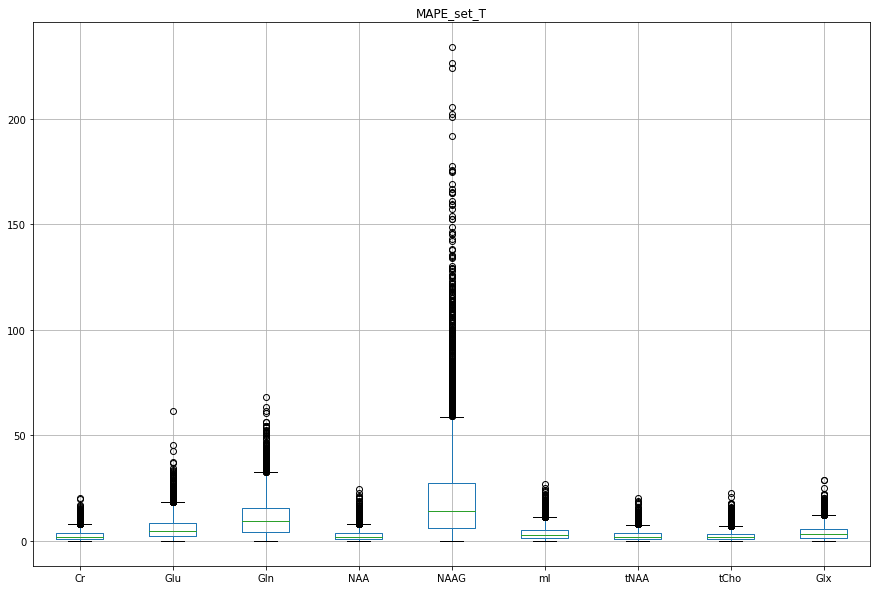

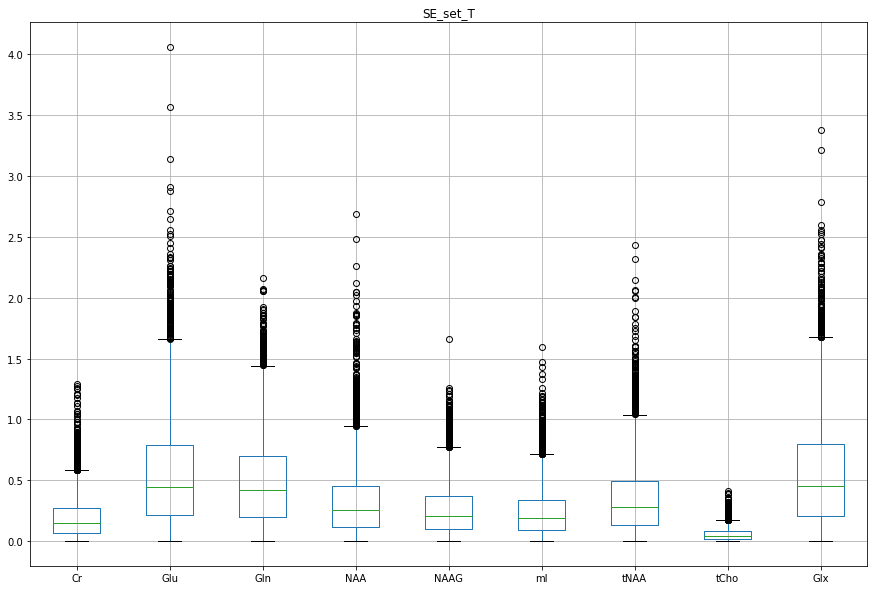

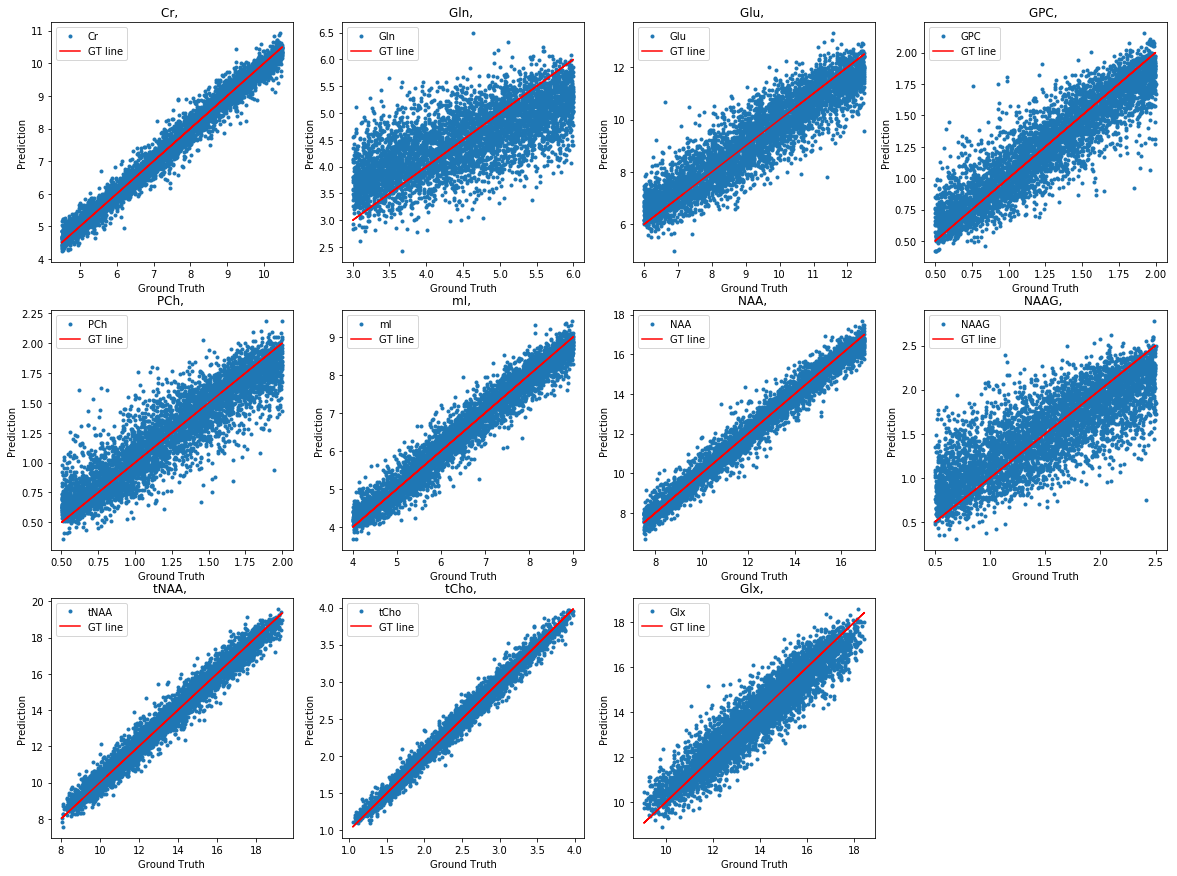

In [24]:
# Change metabo data type to dataframe for stactistic uses, and replace index to metabo name.
brain_metabo_index =  brain_conc_set[0].index
pd_conc_table_test =  pd.DataFrame(conc_table_test).T
pd_conc_table_test = pd_conc_table_test.set_index(brain_metabo_index)

add_metabo_index = list(brain_metabo_index[:-2])

add_metabo_index.extend(['tNAA','tCr','tCho','Glx','Glx/tCr','mI/tCr','tCho/tCr','tNAA/Cr'])
#print(add_metabo_index)
print ([list((i, add_metabo_index[i])) for i in range(len(add_metabo_index))]) 

C_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)
MAPE_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)
SE_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)
#for statstic
Y_conc_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)

rd = np.load(os.path.join(working_dir,'42ppm_base_basis_set.npz'))
#gamma
#rd = np.load(os.path.join(working_dir,'gamma_42ppm_base_basis_set.npz'))

base_basis_set = rd['data']

#[[0, 'Ala'], [1, 'Asp'], [2, 'Cr'], [3, 'GABA'], [4, 'Glc'], [5, 'Gln'], [6, 'Glu'], 
#[7, 'GPC'], [8, 'PCh'], [9, 'Lac'], [10, 'mI'], [11, 'NAA'], [12, 'NAAG'], [13, 'tNAA'], 
#[14, 'tCr'], [15, 'tCho'], [16, 'Glx'], [17, 'Glx/tNAA'], [18, 'mI/tNAA'], [19, 'tCho/tNAA'], [20, 'tCr/tNAA']]

pinv_b = np.linalg.pinv(base_basis_set.real)
print(len(pred_res_view))
for i in tqdm_notebook(range(len(pred_res_view))):
    C = np.matmul(pred_res_view[i].real, pinv_b)
    Y_conc = pd_conc_table_test[i][:-2]
    #MAPE = (abs(Y_conc - C)/Y_conc)*100
    #SE = Y_conc - C    
    #tNAA = NAA + NAAG, [11] + [12]
    C = np.append(C, C[11]+C[12])
    Y_conc = np.append(Y_conc, Y_conc[11]+Y_conc[12])    
    #MAPE = pd.concat([MAPE, MAPE[11]+MAPE[12]], axis=0)
    #tCr = Cr + PCr, [2]+[NA]
    C = np.append(C, C[2])
    Y_conc = np.append(Y_conc, Y_conc[2])
    #tCho = PC + GPC, [8]+[7]
    C = np.append(C, C[8]+C[7])
    Y_conc = np.append(Y_conc, Y_conc[8]+Y_conc[7])
    #Glx = (Gln + Glu), [5]+[6]
    C = np.append(C, C[5]+C[6])
    Y_conc = np.append(Y_conc, Y_conc[5]+Y_conc[6])
    #'Glx/tCr' = [16]/[14]
    C = np.append(C, C[16]/C[14])
    Y_conc = np.append(Y_conc, Y_conc[16]/Y_conc[14])
    #'mI/tCr' = [10]/[14]
    C = np.append(C, C[10]/C[14])
    Y_conc = np.append(Y_conc, Y_conc[10]/Y_conc[14])
    #'tCho/tCr' = [15]/[14]
    C = np.append(C, C[15]/C[14])
    Y_conc = np.append(Y_conc, Y_conc[15]/Y_conc[14])
    #'tNAA/tCr' = [13]/[14]
    C = np.append(C, C[13]/C[14])
    Y_conc = np.append(Y_conc, Y_conc[13]/Y_conc[14])
    MAPE = (abs(Y_conc - C)/Y_conc)*100
    SE = Y_conc - C
    ############
    C_set[i] = C
    Y_conc_set[i] = Y_conc
    MAPE_set[i] = MAPE
    SE_set[i] = SE    
#gamma basis had little different in tNAA....

MAPE_set_T = MAPE_set.loc[["Cr", "Glu",'Gln','NAA','NAAG',"mI","tNAA","tCho","Glx"]].T
print(MAPE_set_T.describe())
plt.figure(figsize=(15,10))
plt.title('MAPE_set_T')
boxplot = MAPE_set_T.boxplot()

#print('Subtraction error, SE')
#print(SE_set.T.describe())

SE_set_T = abs(SE_set.loc[["Cr", "Glu",'Gln','NAA','NAAG',"mI","tNAA","tCho","Glx"]].T)
print(SE_set_T.describe())
plt.figure(figsize=(15,10))
plt.title('SE_set_T')
boxplot = SE_set_T.boxplot()
#plt.ylim(-1,40)

######################################
pred_conc = C_set
GT_conc = Y_conc_set


target = ['Cr','Gln','Glu','GPC','PCh','mI','NAA','NAAG','tNAA','tCho','Glx']
metabo_idx = []
for i in target:
    metabo_idx.append(add_metabo_index.index(i))
print(metabo_idx)

plt.figure(figsize=(20,15))
for idx,cont in enumerate(metabo_idx):
    plt.subplot(3,4,idx+1)
    #plt.title(add_metabo_index[cont])
    plt.title(f'{add_metabo_index[cont]}, ')
    plt.plot(GT_conc.iloc[cont], pred_conc.iloc[cont],'.')
    plt.plot(GT_conc.iloc[cont],GT_conc.iloc[cont],'-r',label='GT line')
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.legend(loc='upper left')

## k-fold quantification

[[0, 'Ala'], [1, 'Asp'], [2, 'Cr'], [3, 'GABA'], [4, 'Glc'], [5, 'Gln'], [6, 'Glu'], [7, 'GPC'], [8, 'PCh'], [9, 'Lac'], [10, 'mI'], [11, 'NAA'], [12, 'NAAG'], [13, 'tNAA'], [14, 'tCr'], [15, 'tCho'], [16, 'Glx'], [17, 'Glx/tCr'], [18, 'mI/tCr'], [19, 'tCho/tCr'], [20, 'tNAA/Cr']]
############## Now is 0 fold##############
Read the 0 model done
5000/5000 [==============================] - ETA: 58 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 292us/step


HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

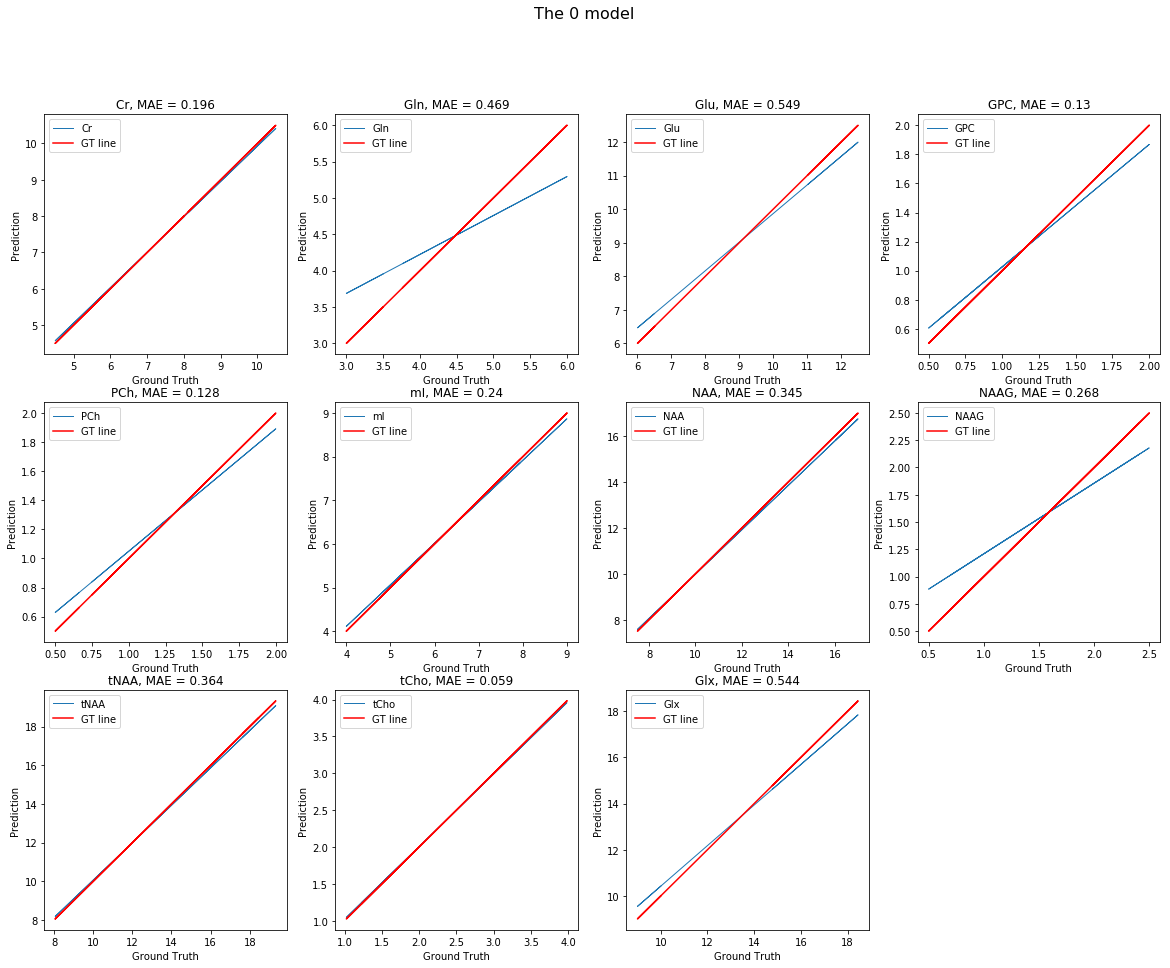

In [38]:
from sklearn.model_selection import KFold,StratifiedKFold
from keras.backend.tensorflow_backend import set_session
from sklearn.linear_model import LinearRegression
from keras.models import load_model

## k-fold model
kfold_model_dir = 'nofc_sgd_default_NormMM_kol_new_logs'
kfold_model_path = os.path.join(working_dir, kfold_model_dir)

sfolder = StratifiedKFold(n_splits=10,random_state=0,shuffle=False)
floder = KFold(n_splits=10,random_state=0,shuffle=False)


##### deconv. need####
brain_metabo_index =  brain_conc_set[0].index
add_metabo_index = list(brain_metabo_index[:-2])
add_metabo_index.extend(['tNAA','tCr','tCho','Glx','Glx/tCr','mI/tCr','tCho/tCr','tNAA/Cr'])
print ([list((i, add_metabo_index[i])) for i in range(len(add_metabo_index))])

pinv_b = np.linalg.pinv(base_basis_set.real)
#print(len(pred_res_view))

##################plot ppm config##################
#for lcm basis, 0
#gamma, 1
choice = 0

basis_sample_point = [4096,4944]
basis_BW = [2500,4823]
basis_B = [127.75, 123.23]

sample_point = basis_sample_point[choice]
BW = basis_BW[choice]
B = basis_B[choice]

ppm_length = BW/B#16.xx ppm
ppm_center = 4.7
min_bound = ppm_center - (ppm_length)/2
max_bound = ppm_center + (ppm_length)/2
ppm = np.linspace(min_bound, max_bound, sample_point)
ppm = ppm[::-1]#reverse

###Original####
pos = np.where((ppm>=0.5) & (ppm<=4.2))
crop_ppm = ppm[pos]
##################plot ppm config##################
##################deconv used##################
def deconv_metabolite(pred_res_view, pinv_b, add_metabo_index, pd_conc_table_test):
    C_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)
    MAPE_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)
    SE_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)
    Y_conc_set = pd.DataFrame(data=np.zeros([len(add_metabo_index),len(pred_res_view)]), index=add_metabo_index)
    rd = np.load(os.path.join(working_dir,'42ppm_base_basis_set.npz'))
    base_basis_set = rd['data']
    for i in tqdm_notebook(range(len(pred_res_view))):
        C = np.matmul(pred_res_view[i].real, pinv_b)
        Y_conc = pd_conc_table_test[i][:-2]
        #tNAA = NAA + NAAG, [11] + [12]
        C = np.append(C, C[11]+C[12])
        Y_conc = np.append(Y_conc, Y_conc[11]+Y_conc[12])
        #tCr = Cr + PCr, [2]+[NA]
        C = np.append(C, C[2])
        Y_conc = np.append(Y_conc, Y_conc[2])
        #tCho = PC + GPC, [8]+[7]
        C = np.append(C, C[8]+C[7])
        Y_conc = np.append(Y_conc, Y_conc[8]+Y_conc[7])    
        #Glx = (Gln + Glu), [5]+[6]
        C = np.append(C, C[5]+C[6])
        Y_conc = np.append(Y_conc, Y_conc[5]+Y_conc[6])
        #'Glx/tCr' = [16]/[14]
        C = np.append(C, C[16]/C[14])
        Y_conc = np.append(Y_conc, Y_conc[16]/Y_conc[14])
        #'mI/tCr' = [10]/[14]
        C = np.append(C, C[10]/C[14])
        Y_conc = np.append(Y_conc, Y_conc[10]/Y_conc[14])
        #'tCho/tCr' = [15]/[14]
        C = np.append(C, C[15]/C[14])
        Y_conc = np.append(Y_conc, Y_conc[15]/Y_conc[14])
        #'tNAA/tCr' = [13]/[14]
        C = np.append(C, C[13]/C[14])
        Y_conc = np.append(Y_conc, Y_conc[13]/Y_conc[14])
        MAPE = (abs(Y_conc - C)/Y_conc)*100
        SE = Y_conc - C
        ############
        C_set[i] = C
        Y_conc_set[i] = Y_conc
        MAPE_set[i] = MAPE
        SE_set[i] = SE
    return C_set, Y_conc_set, MAPE_set, SE_set
##################deconv used##################

def scatter_regression(x, y):
    x_input = x[:,np.newaxis]
    y_input = y
    LR_model=LinearRegression()
    LR_model.fit(x_input, y_input)
    return LR_model.intercept_, LR_model.coef_

kfold_idx = 0
cvscores = []

for train_idx, test_idx in floder.split(read_X[:,:,0].real,read_Y_conc_set):
    print(f'############## Now is {kfold_idx} fold##############')
    ####################rebuild model####################
    #if kfold_idx != 0:
    del model
    keras.backend.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.7
    set_session(tf.Session(config=config))
    ####################rebuild model####################
    ####################Split data####################
    X_train, X_test = read_X[train_idx,:,0], read_X[test_idx,:,0]
    Y_train_conc , Y_test_conc = read_Y_conc_set[train_idx], read_Y_conc_set[test_idx]
    Y_train = Y_train_conc[:,:-15]
    Y_test = Y_test_conc[:,:-15]
    conc_table_train = Y_train_conc[:,-15:].real
    conc_table_test = Y_test_conc[:,-15:].real
    pd_conc_table_test =  pd.DataFrame(conc_table_test).T
    pd_conc_table_test = pd_conc_table_test.set_index(brain_metabo_index)    
    X_train = np.expand_dims(X_train.real, axis = 2)
    X_test = np.expand_dims(X_test.real, axis = 2)    
    ####################Split data####################
    ###################tb##########################
    kfold_model = os.path.join(kfold_model_path,f'{kfold_idx}_TP1.h5')    
    model = load_model(kfold_model)#stable ver. but is to 4.5ppm
    print(f'Read the {kfold_idx} model done')    
    ##################Predict##################
    pred_res = model.predict(X_test, verbose=1)
    pred_res_view = pred_res
    ##################Predict##################
    ##################deconv result##################    
    
    C_set, Y_conc_set, MAPE_set, SE_set = deconv_metabolite(pred_res_view, pinv_b, add_metabo_index,pd_conc_table_test)
    
    '''
    MAPE_set_T = MAPE_set.loc[["Cr", "Glu",'Gln','NAA','NAAG',"mI","tNAA","tCho","Glx"]].T
    #print(MAPE_set_T.describe())
    plt.figure(figsize=(15,10))
    plt.title('MAPE_set_T')
    boxplot = MAPE_set_T.boxplot()

    #print('Subtraction error, SE')
    #print(SE_set.T.describe())
    SE_set_T = abs(SE_set.loc[["Cr", "Glu",'Gln','NAA','NAAG',"mI","tNAA","tCho","Glx"]].T)
    #print(SE_set_T.describe())
    plt.figure(figsize=(15,10))
    plt.title('SE_set_T')
    boxplot = SE_set_T.boxplot()
    #plt.ylim(-1,40)
    '''
    ######################################
    pred_conc = C_set
    GT_conc = Y_conc_set
    target = ['Cr','Gln','Glu','GPC','PCh','mI','NAA','NAAG','tNAA','tCho','Glx']
    metabo_idx = []
    for i in target:
        metabo_idx.append(add_metabo_index.index(i))
    #print(metabo_idx)
    ## type 1
    '''
    MAE_set = np.mean(abs(SE_set),axis = 1)
    plt.figure(figsize=(20,15))
    plt.suptitle(f'The {kfold_idx} model',fontsize=16)
    for idx,cont in enumerate(metabo_idx):
        plt.subplot(3,4,idx+1)
        #plt.title(add_metabo_index[cont])
        plt.title(f'{add_metabo_index[cont]}, MAE = {round(MAE_set[cont],3)}')
        plt.plot(GT_conc.iloc[cont], pred_conc.iloc[cont],'.')
        plt.plot(GT_conc.iloc[cont],GT_conc.iloc[cont],'-r',label='GT line')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.legend(loc='upper left')
    '''
    ##type 2
    MAE_set = np.mean(abs(SE_set),axis = 1)
    plt.figure(figsize=(20,15))
    plt.suptitle(f'The {kfold_idx} model',fontsize=16)
    for idx,cont in enumerate(metabo_idx):
        plt.subplot(3,4,idx+1)
        #plt.title(add_metabo_index[cont])
        lr_intercept , lr_coef = scatter_regression(GT_conc.iloc[cont], pred_conc.iloc[cont])
        plt.title(f'{add_metabo_index[cont]}, MAE = {round(MAE_set[cont],3)}')
        plt.plot(GT_conc.iloc[cont],lr_intercept+lr_coef*GT_conc.iloc[cont],linewidth=1)
        plt.plot(GT_conc.iloc[cont],GT_conc.iloc[cont],'-r',label='GT line')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.legend(loc='upper left')
    ##################deconv result##################    
    break
    #sav_filename_path = os.path.join(kfold_model_path,f'{kfold_idx}_TP1.png')
    #plt.savefig(sav_filename_path)
    '''
    ##############Error bar##############
    FWHM_test = broaden_FWHM_set[test_idx]
    boarden_t2_test = boarden_t2_set[test_idx]
    AWGN_db_test = AWGN_db_set[test_idx]

    target = ['Cr','Gln','Glu','GPC','PCh','mI','NAA','NAAG','tNAA','tCho','Glx']
    metabo_idx = []
    for i in target:
        metabo_idx.append(add_metabo_index.index(i))    
    for idx,cont in enumerate(metabo_idx):
        plt.figure(1,figsize=(18,15))
        plt.subplot(3,4,idx+1)
        plt.title(add_metabo_index[cont])
        #plt.plot(boarden_t2_test, abs(SE_set.iloc[cont]),'.')
        x_label, y_mean_set, y_std_set = errorbar_array(boarden_t2_test, np.array(abs(SE_set.iloc[cont])))
        plt.errorbar(x_label, y_mean_set, y_std_set, marker='^')    
        plt.xlabel('Boarden_t2')
        plt.ylabel('Subtraction error')
        #plt.legend(loc='upper left')

        #############################
        plt.figure(2,figsize=(18,20))
        plt.subplot(4,4,idx+1)
        plt.title(add_metabo_index[cont])
        x_label, y_mean_set, y_std_set = errorbar_array(AWGN_db_test, np.array(abs(SE_set.iloc[cont])))
        plt.errorbar(x_label, y_mean_set, y_std_set, marker='^')    
        #plt.plot(AWGN_db_test, abs(SE_set.iloc[cont]),'.')
        plt.xlabel('SNR')
        plt.ylabel('Subtraction error')
        #plt.legend(loc='upper left')
        #############################
        plt.figure(3,figsize=(18,20))
        plt.subplot(4,4,idx+1)
        plt.title(add_metabo_index[cont])
        x_label, y_mean_set, y_std_set = errorbar_array(FWHM_test, np.array(abs(SE_set.iloc[cont])))
        plt.errorbar(x_label, y_mean_set, y_std_set, marker='^')    
        #plt.plot(AWGN_db_test, abs(SE_set.iloc[cont]),'.')
        plt.xlabel('broaden_FWHM_set')
        plt.ylabel('Subtraction error')
        plt.xlim(x_label.max(),x_label.min())    
        
    ##############Error bar##############
    '''    
    kfold_idx += 1

In [6]:
import time
from tqdm import tnrange, tqdm_notebook
import pandas as pd

######################################
# Load other parameters
######################################

other_params_path = os.path.join(gen_folder_path, 'other_parameters')
#other_params_path = os.path.join(gen_folder_path, '0225')
other_params_files = [ f for f in os.listdir(other_params_path) if os.path.isfile(os.path.join(other_params_path,f)) ]

boarden_t2_set = np.zeros((50000,),dtype=np.int)
AWGN_db_set = np.zeros((50000,),dtype=np.int)
broaden_FWHM_nosnr_set = np.zeros((50000,),dtype=np.int)
broaden_FWHM_set = np.zeros((50000,),dtype=np.int)

for idx, cont in enumerate(tqdm_notebook(other_params_files)):
    read_data= np.load(os.path.join(other_params_path, cont))
    boarden_t2_set[idx,] = read_data['var_boarden_t2']
    AWGN_db_set[idx,] = read_data['var_AWGN_db']
    broaden_FWHM_nosnr_set[idx,] = read_data['broaden_FWHM_nosnr']
    broaden_FWHM_set[idx,] = read_data['broaden_FWHM']

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

In [8]:
def errorbar_array(x, y):#input np
    #x_label = np.unique(x)#5000 => N種
    x_label = np.unique(np.ceil(x/5)*5)#5000 => N種,在 FWHM情況下將橫軸以差距5來區分
    #x_label = np.unique(np.ceil(x/1)*1)#5000 => N種,在 FWHM情況下將橫軸以差距5來區分
    y_mean_set = np.zeros(len(x_label),)
    y_std_set = np.zeros(len(x_label),)
    for idx,cont in enumerate(x_label):
        label_idx = np.where(x == x_label[idx])
        y_value = y[label_idx]
        y_mean_set[idx],y_std_set[idx] = np.mean(y_value), np.std(y_value)
    return x_label,y_mean_set,y_std_set

[2, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16]


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\figure.py:98: MatplotlibD

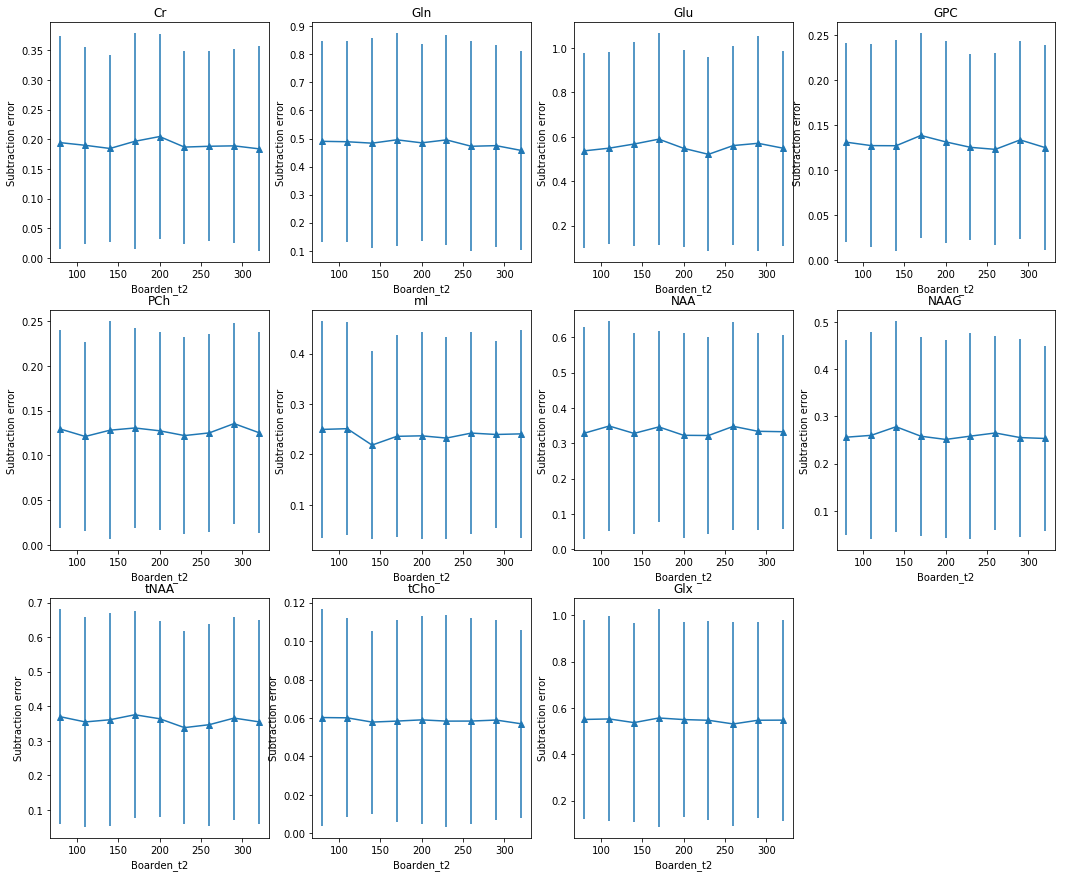

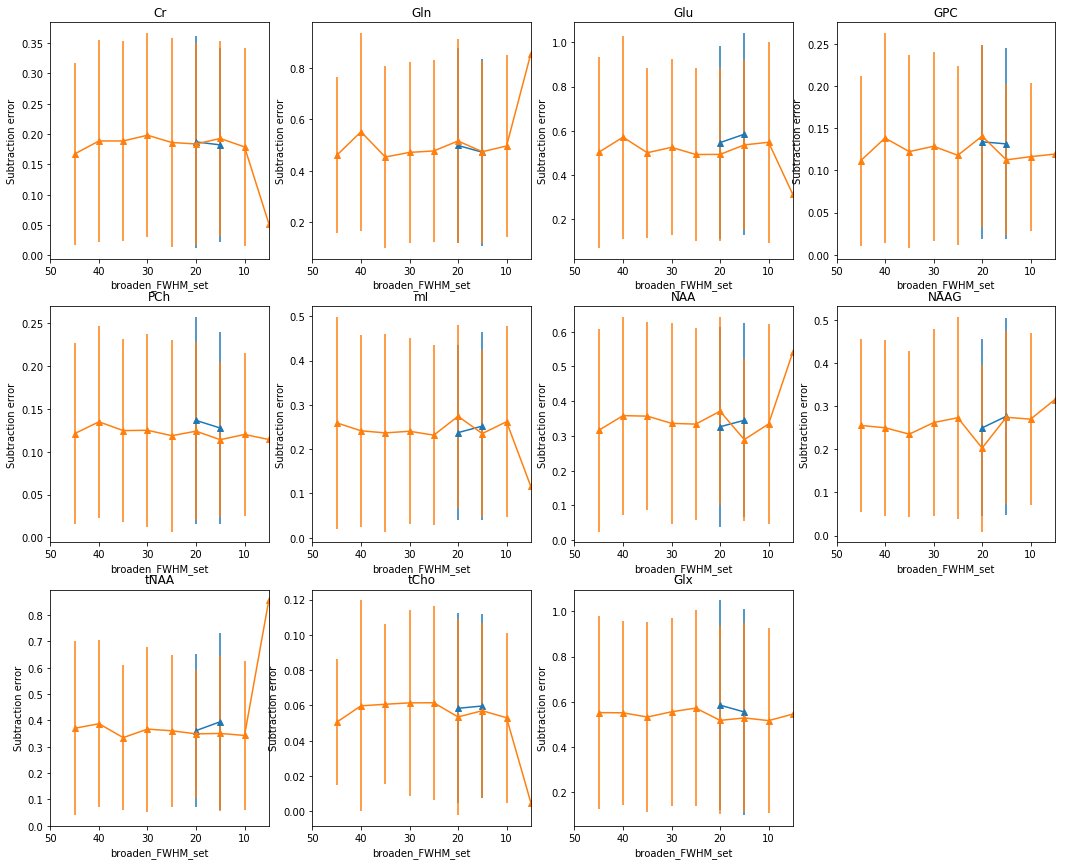

In [51]:
def errorbar_array(x, y):#input np
    #x_label = np.unique(x)#5000 => N種
    x_label = np.unique(np.ceil(x/5)*5)#5000 => N種,在 FWHM情況下將橫軸以差距5來區分
    #x_label = np.unique(np.ceil(x/1)*1)#5000 => N種,在 FWHM情況下將橫軸以差距5來區分
    y_mean_set = np.zeros(len(x_label),)
    y_std_set = np.zeros(len(x_label),)
    for idx,cont in enumerate(x_label):
        label_idx = np.where(x == x_label[idx])
        y_value = y[label_idx]
        y_mean_set[idx],y_std_set[idx] = np.mean(y_value), np.std(y_value)
    return x_label,y_mean_set,y_std_set

'''
plt.figure()
plt.hist(boarden_t2_set,bins=30)
plt.figure()
plt.hist(AWGN_db_set)
'''
boarden_t2_train, boarden_t2_test, AWGN_db_train , AWGN_db_test = train_test_split(boarden_t2_set, AWGN_db_set, test_size = 0.1, random_state = 42)
FWHM_nosnr_train, FWHM_nosnr_test, FWHM_train , FWHM_test = train_test_split(broaden_FWHM_nosnr_set, broaden_FWHM_set, test_size = 0.1, random_state = 42)

target = ['Cr','Gln','Glu','GPC','PCh','mI','NAA','NAAG','tNAA','tCho','Glx']
metabo_idx = []
for i in target:
    metabo_idx.append(add_metabo_index.index(i))
print(metabo_idx)
'''
for idx,cont in enumerate(metabo_idx):
    plt.figure(1,figsize=(18,15))
    plt.subplot(3,4,idx+1)
    plt.title(add_metabo_index[cont])
    #plt.plot(boarden_t2_test, abs(SE_set.iloc[cont]),'.')
    x_label, y_mean_set, y_std_set = errorbar_array(boarden_t2_test, np.array(abs(SE_set.iloc[cont])))
    plt.errorbar(x_label, y_mean_set, y_std_set, marker='^')    
    plt.xlabel('Boarden_t2')
    plt.ylabel('Subtraction error')
    #plt.legend(loc='upper left')
    
    #############################
    plt.figure(2,figsize=(18,20))
    plt.subplot(4,4,idx+1)
    plt.title(add_metabo_index[cont])
    x_label, y_mean_set, y_std_set = errorbar_array(AWGN_db_test, np.array(abs(SE_set.iloc[cont])))
    plt.errorbar(x_label, y_mean_set, y_std_set, marker='^')    
    #plt.plot(AWGN_db_test, abs(SE_set.iloc[cont]),'.')
    plt.xlabel('SNR')
    plt.ylabel('Subtraction error')
    #plt.legend(loc='upper left')
'''
#plt.plot(broaden_FWHM_set)
for idx,cont in enumerate(metabo_idx):
    #############################
    plt.figure(2,figsize=(18,20))
    plt.subplot(4,4,idx+1)
    plt.title(add_metabo_index[cont])
    x_label, y_mean_set, y_std_set = errorbar_array(FWHM_test, np.array(abs(SE_set.iloc[cont])))
    plt.errorbar(x_label, y_mean_set, y_std_set, marker='^')    
    #plt.plot(AWGN_db_test, abs(SE_set.iloc[cont]),'.')
    plt.xlabel('broaden_FWHM_set')
    plt.ylabel('Subtraction error')
    plt.xlim(x_label.max(),x_label.min())    
    #plt.legend(loc='upper left')

## Kfold SNR error plot

In [54]:
kfold_idx = 0
cvscores = []

for train_idx, test_idx in floder.split(read_X[:,:,0].real,read_Y_conc_set):
    print(f'############## Now is {kfold_idx} fold##############')
    ####################rebuild model####################
    #if kfold_idx != 0:
    del model
    keras.backend.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.7
    set_session(tf.Session(config=config))
    ####################rebuild model####################
    ####################Split data####################
    X_train, X_test = read_X[train_idx,:,0], read_X[test_idx,:,0]
    Y_train_conc , Y_test_conc = read_Y_conc_set[train_idx], read_Y_conc_set[test_idx]
    Y_train = Y_train_conc[:,:-15]
    Y_test = Y_test_conc[:,:-15]
    conc_table_train = Y_train_conc[:,-15:].real
    conc_table_test = Y_test_conc[:,-15:].real
    pd_conc_table_test =  pd.DataFrame(conc_table_test).T
    pd_conc_table_test = pd_conc_table_test.set_index(brain_metabo_index)    
    X_train = np.expand_dims(X_train.real, axis = 2)
    X_test = np.expand_dims(X_test.real, axis = 2)    
    ####################Split data####################
    ###################tb##########################
    kfold_model = os.path.join(kfold_model_path,f'{kfold_idx}_TP1.h5')    
    model = load_model(kfold_model)#stable ver. but is to 4.5ppm
    print(f'Read the {kfold_idx} model done')    
    ##################Predict##################
    pred_res = model.predict(X_test, verbose=1)
    pred_res_view = pred_res
    ##################Predict##################
    ##################deconv result##################    
    C_set, Y_conc_set, MAPE_set, SE_set = deconv_metabolite(pred_res_view, pinv_b, add_metabo_index,pd_conc_table_test)
    
    ##############SNR vs Error bar##############
    #boarden_t2_train, boarden_t2_test, AWGN_db_train , AWGN_db_test = train_test_split(boarden_t2_set, AWGN_db_set, test_size = 0.1, random_state = 42)
    FWHM_test = broaden_FWHM_set[test_idx]
    
    #FWHM_nosnr_train, FWHM_nosnr_test, FWHM_train , FWHM_test = train_test_split(broaden_FWHM_nosnr_set, broaden_FWHM_set, test_size = 0.1, random_state = 42)

    target = ['Cr','Gln','Glu','GPC','PCh','mI','NAA','NAAG','tNAA','tCho','Glx']
    metabo_idx = []
    for i in target:
        metabo_idx.append(add_metabo_index.index(i))
    print(metabo_idx)
    #plt.plot(broaden_FWHM_set)
    for idx,cont in enumerate(metabo_idx):
        #############################
        plt.figure(2,figsize=(18,20))
        plt.subplot(4,4,idx+1)
        plt.title(add_metabo_index[cont])
        x_label, y_mean_set, y_std_set = errorbar_array(FWHM_test, np.array(abs(SE_set.iloc[cont])))
        plt.errorbar(x_label, y_mean_set, y_std_set, marker='^')    
        #plt.plot(AWGN_db_test, abs(SE_set.iloc[cont]),'.')
        plt.xlabel('broaden_FWHM_set')
        plt.ylabel('Subtraction error')
        plt.xlim(x_label.max(),x_label.min())    
        #plt.legend(loc='upper left')    
    ##############SNR vs Error bar##############
    
    #sav_filename_path = os.path.join(kfold_model_path,f'{kfold_idx}_TP1.png')
    #plt.savefig(sav_filename_path)
    kfold_idx += 1

############## Now is 0 fold##############
Read the 0 model done
5000/5000 [==============================] - ETA: 56 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 283us/step


HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

ValueError: Length of values does not match length of index